In [37]:
from collections import Counter

import nltk
import spacy
import re
import requests
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
from spacy import displacy
from bs4 import BeautifulSoup


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
!python3 -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt to /home/yurii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yurii/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/yurii/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/yurii/nltk_data...
[nltk_data]   Package words is already up-to-date!


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [13]:
input_str = 'European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices'

### NLTK

Apply **word tokenization** and **part of speech** tagging:

In [14]:
def preprocess(some_text):
    some_text = nltk.word_tokenize(some_text)
    some_text = nltk.pos_tag(some_text)
    return some_text

In [15]:
%time

preprocessed_str = preprocess(input_str)
preprocessed_str

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


[('European', 'JJ'),
 ('authorities', 'NNS'),
 ('fined', 'VBD'),
 ('Google', 'NNP'),
 ('a', 'DT'),
 ('record', 'NN'),
 ('$', '$'),
 ('5.1', 'CD'),
 ('billion', 'CD'),
 ('on', 'IN'),
 ('Wednesday', 'NNP'),
 ('for', 'IN'),
 ('abusing', 'VBG'),
 ('its', 'PRP$'),
 ('power', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('mobile', 'JJ'),
 ('phone', 'NN'),
 ('market', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('company', 'NN'),
 ('to', 'TO'),
 ('alter', 'VB'),
 ('its', 'PRP$'),
 ('practices', 'NNS')]

The tuples above contain words and appropriate part of speech.

Now extract nouns with regex filter


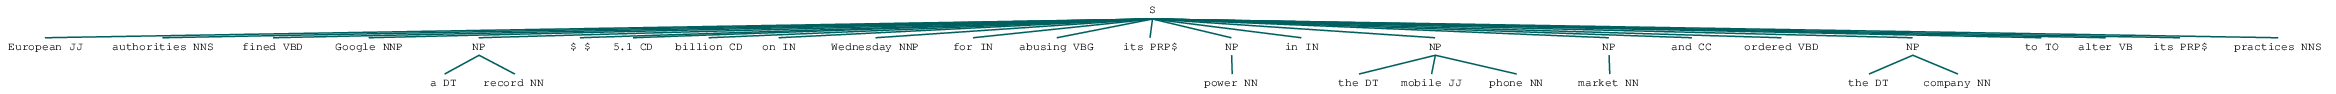

In [16]:
pattern = r'NP: {<DT>?<JJ>*<NN>}'
regex_parser = nltk.RegexpParser(pattern)
chunks = regex_parser.parse(preprocessed_str)
chunks

Use IOB (*inside-outside beginning tagging*) tags to represent chunk structure in files

In [17]:
iob_tagged = tree2conlltags(chunks)
iob_tagged

[('European', 'JJ', 'O'),
 ('authorities', 'NNS', 'O'),
 ('fined', 'VBD', 'O'),
 ('Google', 'NNP', 'O'),
 ('a', 'DT', 'B-NP'),
 ('record', 'NN', 'I-NP'),
 ('$', '$', 'O'),
 ('5.1', 'CD', 'O'),
 ('billion', 'CD', 'O'),
 ('on', 'IN', 'O'),
 ('Wednesday', 'NNP', 'O'),
 ('for', 'IN', 'O'),
 ('abusing', 'VBG', 'O'),
 ('its', 'PRP$', 'O'),
 ('power', 'NN', 'B-NP'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'B-NP'),
 ('mobile', 'JJ', 'I-NP'),
 ('phone', 'NN', 'I-NP'),
 ('market', 'NN', 'B-NP'),
 ('and', 'CC', 'O'),
 ('ordered', 'VBD', 'O'),
 ('the', 'DT', 'B-NP'),
 ('company', 'NN', 'I-NP'),
 ('to', 'TO', 'O'),
 ('alter', 'VB', 'O'),
 ('its', 'PRP$', 'O'),
 ('practices', 'NNS', 'O')]

Above is IOB chunks representation. There is one token per line including **part of speech** & **named entity tag**. This representation allows to create the tagger for labelling new sentences and convert tag sequences to tree structure later

In [18]:
ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(input_str)))
print(dir(ne_tree))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', '__weakref__', '_frozen_class', '_get_node', '_label', '_parse_error', '_pformat_flat', '_repr_png_', '_set_node', 'append', 'chomsky_normal_form', 'clear', 'collapse_unary', 'convert', 'copy', 'count', 'draw', 'extend', 'flatten', 'freeze', 'fromstring', 'height', 'index', 'insert', 'label', 'leaf_treeposition', 'leaves', 'node', 'pformat', 'pformat_latex_qtree', 'pop', 'pos', 'pprint', 'pretty_print', 'productions', 'remove', 'reverse', 'set_label', 'sort', 'subtrees', 'treeposi

In [19]:
ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(input_str)))
print(ne_tree.productions()[1:])

[GPE -> ('European', 'JJ'), PERSON -> ('Google', 'NNP')]


###  Spacy

In [22]:
import en_core_web_sm
nlp = en_core_web_sm.load()

Parse entities:

* NORD - nationalities or religious or political groups
* ORG  - organizations

In [25]:
doc = nlp(input_str)
[(X.text, X.label_) for X in doc.ents]

[('European', 'NORP'),
 ('Google', 'ORG'),
 ('$5.1 billion', 'MONEY'),
 ('Wednesday', 'DATE')]

Though it could not locate programming languages

In [28]:
py_description = "Python is an easy to learn, powerful programming language. It has efficient high-level data structures and a simple but effective approach to object-oriented programming. Python’s elegant syntax and dynamic typing, together with its interpreted nature, make it an ideal language for scripting and rapid application development in many areas on most platforms."
py_doc = nlp(py_description)
[(X.text, X.label_) for X in py_doc.ents]

[]

In [29]:
[(X, X.ent_iob_, X.ent_type_) for X in doc]

[(European, 'B', 'NORP'),
 (authorities, 'O', ''),
 (fined, 'O', ''),
 (Google, 'B', 'ORG'),
 (a, 'O', ''),
 (record, 'O', ''),
 ($, 'B', 'MONEY'),
 (5.1, 'I', 'MONEY'),
 (billion, 'I', 'MONEY'),
 (on, 'O', ''),
 (Wednesday, 'B', 'DATE'),
 (for, 'O', ''),
 (abusing, 'O', ''),
 (its, 'O', ''),
 (power, 'O', ''),
 (in, 'O', ''),
 (the, 'O', ''),
 (mobile, 'O', ''),
 (phone, 'O', ''),
 (market, 'O', ''),
 (and, 'O', ''),
 (ordered, 'O', ''),
 (the, 'O', ''),
 (company, 'O', ''),
 (to, 'O', ''),
 (alter, 'O', ''),
 (its, 'O', ''),
 (practices, 'O', '')]

In [32]:
[(X, X.ent_iob_, X.ent_type_) for X in py_doc]

[(Python, 'O', ''),
 (is, 'O', ''),
 (an, 'O', ''),
 (easy, 'O', ''),
 (to, 'O', ''),
 (learn, 'O', ''),
 (,, 'O', ''),
 (powerful, 'O', ''),
 (programming, 'O', ''),
 (language, 'O', ''),
 (., 'O', ''),
 (It, 'O', ''),
 (has, 'O', ''),
 (efficient, 'O', ''),
 (high, 'O', ''),
 (-, 'O', ''),
 (level, 'O', ''),
 (data, 'O', ''),
 (structures, 'O', ''),
 (and, 'O', ''),
 (a, 'O', ''),
 (simple, 'O', ''),
 (but, 'O', ''),
 (effective, 'O', ''),
 (approach, 'O', ''),
 (to, 'O', ''),
 (object, 'O', ''),
 (-, 'O', ''),
 (oriented, 'O', ''),
 (programming, 'O', ''),
 (., 'O', ''),
 (Python, 'O', ''),
 (’s, 'O', ''),
 (elegant, 'O', ''),
 (syntax, 'O', ''),
 (and, 'O', ''),
 (dynamic, 'O', ''),
 (typing, 'O', ''),
 (,, 'O', ''),
 (together, 'O', ''),
 (with, 'O', ''),
 (its, 'O', ''),
 (interpreted, 'O', ''),
 (nature, 'O', ''),
 (,, 'O', ''),
 (make, 'O', ''),
 (it, 'O', ''),
 (an, 'O', ''),
 (ideal, 'O', ''),
 (language, 'O', ''),
 (for, 'O', ''),
 (scripting, 'O', ''),
 (and, 'O', ''),
 (ra

#### Parse webpage & extract named entities

In [38]:
def url_to_string(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    for script in soup(["script", "style", 'aside']):
        script.extract()
    return " ".join(re.split(r'[\n\t]+', soup.get_text()))
ny_bb = url_to_string('https://www.nytimes.com/2018/08/13/us/politics/peter-strzok-fired-fbi.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news')
article = nlp(ny_bb)
len(article.ents)

174

In [39]:
labels = [x.label_ for x in article.ents]
Counter(labels)

Counter({'PERSON': 82,
         'GPE': 16,
         'CARDINAL': 5,
         'ORG': 39,
         'DATE': 24,
         'NORP': 2,
         'ORDINAL': 1,
         'FAC': 1,
         'PRODUCT': 2,
         'LOC': 1,
         'TIME': 1})

In [40]:
items = [x.text for x in article.ents]
Counter(items).most_common(3)

[('Strzok', 28), ('F.B.I.', 13), ('Trump', 12)]

In [48]:
sentences = [x for x in article.sents]
print(sentences[-1])

The New York Times CompanyContact UsWork with usAdvertiseYour Ad ChoicesPrivacyTerms of ServiceTerms of SaleSite MapHelpHelpSubscriptions                                                           


In [50]:
displacy.render(nlp(str(sentences)), jupyter=True, style='ent')

In [53]:
displacy.render(nlp(str(sentences[-1])), style='dep', jupyter = True, options = {'distance': 120})

In [55]:
[(x.orth_,x.pos_, x.lemma_) for x in [y 
                                      for y
                                      in nlp(str(sentences[-1])) 
                                      if not y.is_stop and y.pos_ != 'PUNCT']]

[('New', 'PROPN', 'New'),
 ('York', 'PROPN', 'York'),
 ('Times', 'PROPN', 'Times'),
 ('CompanyContact', 'PROPN', 'CompanyContact'),
 ('UsWork', 'PROPN', 'UsWork'),
 ('usAdvertiseYour', 'PROPN', 'usAdvertiseYour'),
 ('Ad', 'PROPN', 'Ad'),
 ('ChoicesPrivacyTerms', 'NOUN', 'choicesprivacyterm'),
 ('ServiceTerms', 'PROPN', 'ServiceTerms'),
 ('SaleSite', 'PROPN', 'SaleSite'),
 ('MapHelpHelpSubscriptions', 'NOUN', 'maphelphelpsubscription'),
 ('                                                          ',
  'SPACE',
  '                                                          ')]